# SciPy's probability distributions, ufuncs, and unit testing

In [1]:
import numpy as np
import scipy
from scipy import stats, integrate
import matplotlib as mpl

from matplotlib.pyplot import *
from numpy import *

# ion()  # this used to be needed in notebooks...

## SciPy's probability distributions

The `stats` module in SciPy contains lots of useful statistical objects (functions and class instances), including distribution objects implementing calculations for a wide variety of discrete and continuous distributions. The calculations include evaluating PMFs and PDFs, cumulative distribution functions (CDFs), inverse CDFs (aka, percentage-point functions, PPFs), moments, and even parameter fitting.

We'll take a quick look at the `scipy.stats` distributions here by computing the posterior for the binomial inference problem covered in Lec05.  We'll compute it using the (discrete) binomial distribution to compute a likelihood function, converting it to a posterior via Bayes's theorem, using a uniform prior. The uniform prior here is just the constant, 1, but let's use the (continuous) beta distribution for it, noting that $\mathop{\rm Beta}(1,1)$ is a uniform distribution over $[0,1]$.

In [2]:
# Use introspection to see basic docs for SciPy's beta dist'n.
stats.beta?

A more readable version of the docs is available via a documentation browser like Dash (macOS), or in the SciPy online docs: [scipy.stats.beta — SciPy v1.8.0 Manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html).

In [3]:
prior = stats.beta(1, 1)  # flat prior as a "frozen" beta object

(0.0, 1.2)

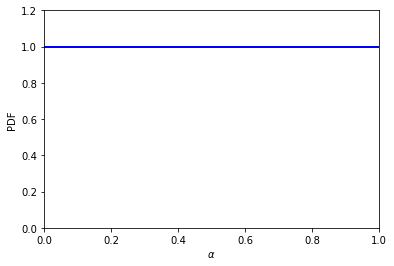

In [4]:
# Plot the prior.

alphas = linspace(0., 1., 200)
plot(alphas, prior.pdf(alphas), 'b-', lw=2, label='Prior')

# Always label axes!
xlabel(r'$\alpha$')
ylabel('PDF')
xlim(0, 1)
ylim(0, 1.2)

For color choices, see: [Colors, color cycles, and colormaps — Matplotlib documentation](https://matplotlib.org/stable/users/prev_whats_new/dflt_style_changes.html#colors-color-cycles-and-colormaps) for the default set (~10 colors), and [Specifying Colors](https://matplotlib.org/tutorials/colors/colors.html#sphx-glr-tutorials-colors-colors-py) for full details.

Now let's build the likelihood function.

In [5]:
# Binomial docs:
stats.binom?

We'll define the likelihood function in a way that appears to take a single `alpha` value as its input. But we'll take advantage of some NumPy/SciPy magic to automatically evaluate the function over an array of `alpha` values.

Text(0, 0.5, 'Likelihood')

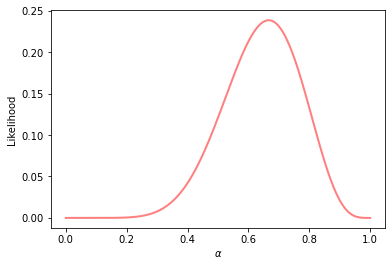

In [6]:
def like(alpha, n, ntot):
    """
    Likelihood function for `alpha`, the success probability in a binomial
    sampling dist'n for `n` successes in `ntot` trials.
    """
    return stats.binom.pmf(n, ntot, alpha)

n, ntot = 8, 12  # n successes in ntot trials

# Save the likelihood values for use in posterior.
lvals = like(alphas, n, ntot)  # note alphas is an array

plot(alphas, lvals, 'r-', lw=2, alpha=.5, label='Like')
xlabel(r'$\alpha$')
ylabel('Likelihood')


This worked because `stats.binom.pmf` is a "universal function" or *ufunc*: a function that can take a NumPy `ndarray` argument (of any dimension, including a "0-dimensional" scalar) and apply the function across the array.  For more, see: [Universal functions (ufunc) — NumPy Manual](https://docs.scipy.org/doc/numpy/reference/ufuncs.html).

Now let's compute the marginal likelihood—the normalization constant—via numerical integration with the trapezoid rule. SciPy has an `integrate` module that includes a `trapz` function implementing the trapezoid rule. Pay close attention to the order of its arguments! To enable the function to handle cases with both equally-spaced and unequally-spaced nodes ($x$ values), the $y$ values appear first in the argument list. 

In [7]:
# Docs for trapezoid quadrature rule (basic numerical integration):
integrate.trapz?

In [8]:
# Marginal likelihood calculation:
mlike = integrate.trapz(prior.pdf(alphas)*lvals, alphas)
print('Marg. likelihood:', mlike)

Marg. likelihood: 0.07692307692332988


Posterior norm: 0.9999999999999998


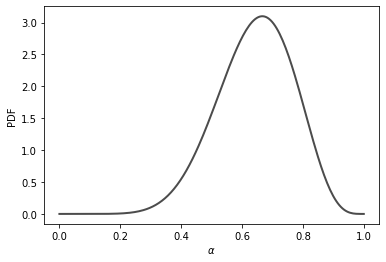

In [9]:
# Plot the posterior.

ppdf = prior.pdf(alphas)*lvals/mlike
plot(alphas, ppdf, 'k-', lw=2, alpha=.7, label='Post')

xlabel(r'$\alpha$')
ylabel('PDF')

# Check the normalization:
print('Posterior norm:', integrate.trapz(ppdf, alphas))

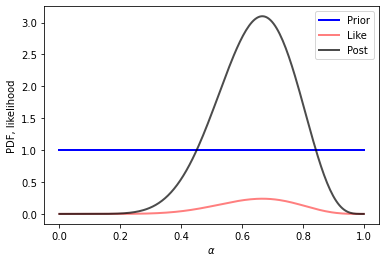

In [10]:
# All together now, making use of labels to include a legend:

plot(alphas, prior.pdf(alphas), 'b-', lw=2, label='Prior')
plot(alphas, lvals, 'r-', lw=2, alpha=.5, label='Like')
plot(alphas, prior.pdf(alphas)*lvals/mlike, 'k-', lw=2, alpha=.7, label='Post')

xlabel(r'$\alpha$')
ylabel('PDF, likelihood')
legend()

Well, that plot has the right idea, but it's a bit inconvenient having the likelihood function span such a small vertical range, just because it shares an ordinate with the prior and posterior. Remember, $\mathcal{L}(\alpha)$ is not a PDF for $\alpha$, so it doesn't even have the same units as the prior and posterior in general, and it shouldn't be plotted against the same axis (though here all the functions are dimensionless).

To highlight that the likelihood is not a PDF, let's give it its own axis, on the right.  We'll build a simple Python class to implement a dual-ordinate figure, with methods to switch between axes as needed.

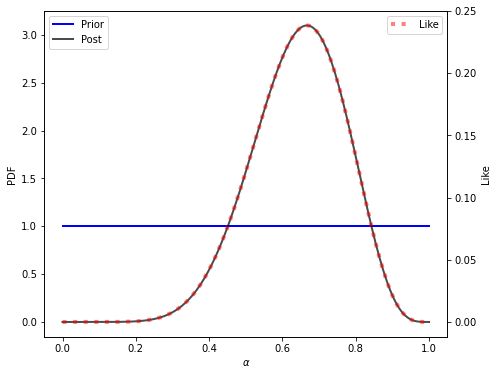

In [11]:
class FigLRAxes:
    """
    A figure with two ordinate axes (left and right) sharing a common
    abscissa axis.
    
    In matplotlib lingo, this is a two-scale plot using twinx().
    """

    def __init__(self, figsize=(8,6), l=0.15, r=0.85):
        self.fig = figure(figsize=figsize)
        # Left and right axes:
        self.leftax = self.fig.add_subplot(111)
        self.fig.subplots_adjust(left=l, right=r)
        self.rightax = self.leftax.twinx()
        # Use thicker frame lines.
        self.leftax.patch.set_lw(1.25)  # thicker frame lines
        self.rightax.patch.set_lw(1.25)  # thicker frame lines
        # Leave with the left axes as current.
        self.fig.sca(self.leftax)

    def left(self):
        self.fig.sca(self.leftax)
        return self.leftax

    def right(self):
        self.fig.sca(self.rightax)
        return self.rightax

fig = FigLRAxes()

# Prior, posterior against left axis:
plot(alphas, prior.pdf(alphas), 'b-', lw=2, label='Prior')
plot(alphas, prior.pdf(alphas)*lvals/mlike, 'k-', lw=2, alpha=.7, label='Post')
xlabel(r'$\alpha$')
ylabel('PDF')
legend(loc='upper left')

# Likelihood against the right axis:
fig.right()
plot(alphas, lvals, 'r:', lw=4, alpha=.5, label='Like')
ylabel('Like')
legend(loc='upper right')

# NOTE:  The posterior/likelihood overlap here is an accident of the
# L and R default axis limit choices.

I chose ordinate ranges here so the likelihood resembles the posterior, but that's really just a visual coincidence, so to speak. The ticks on the left and right reveal that the posterior PDF and the likelihood actually take very different values, even though they have the same shape (a consequence of using a flat prior).

## Vector operations and broadcasting

We could get the likelihoods with an explicit `for` loop over alphas, instead of exploiting ufuncs, as follows.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


Text(0, 0.5, 'Like via looping')

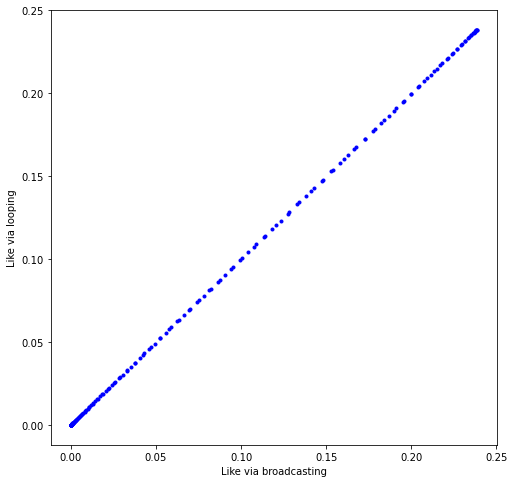

In [12]:
def like_loop(alphas, n, ntot):
    """
    Likelihood function for `alphas`, a sequence of success probabilities 
    for binomial sampling dist'ns for `n` successes in `ntot` trials.
    
    This computes the likelihood via explicit looping over the values
    in `alphas`.
    """
    lvals = empty_like(alphas)
    for i in range(len(alphas)):
        lvals[i] = stats.binom.pmf(n, ntot, alphas[i])
    return lvals

llvals = like_loop(alphas, n, ntot)
print(llvals - lvals)

figure(figsize=[8,8])
plot(lvals, llvals, 'b.')
xlabel('Like via broadcasting')
ylabel('Like via looping')

So what's the difference? **Speed** (which you may have noticed when executing that cell vs. cells using ufuncs). NumPy's ufuncs execute loops over array contents in compiled C code, rather than using the Python virtual machine to loop over Python operations on objects.

We'll compare them here using the IPython "magic" command, `%time`. Learn more about timing and profiling Python code here: [Profiling and Timing Code | Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html).

***Note:*** "Magic commands" are IPython kernel capabilities that aren't part of the normal Python interpreter; see: [Built-in magic commands — IPython documentation](https://ipython.readthedocs.io/en/stable/interactive/magics.html).

In [13]:
alphas = linspace(0., 1., 100000)

%time lvals = like(alphas, n, ntot)

CPU times: user 12.1 ms, sys: 1.48 ms, total: 13.6 ms
Wall time: 13 ms


In [14]:
%time llvals = like_loop(alphas, n, ntot)

CPU times: user 6.82 s, sys: 147 ms, total: 6.97 s
Wall time: 7.4 s


Wow, `like_loop` sure is **slow**!

### Moral

**Avoid explicit looping whenever possible**.  Use ufuncs whenever possible. Most of NumPy's familiar numerical functions (`exp`, `log`, `log10`, `sin`, `cos`, etc.) are ufuncs, as are SciPy's special functions and many methods for probability distribution objects.

## Unit tests

We implemented a sanity check above, printing the integral of the posterior (which should be 1).  Ideally, all code should be tested, explicitly, as throroughly as possible.

*Unit testing* refers to testing code at or near the lowest level of modularity: constructing one or more tests for any function or method in the code. In contrast, *functional testing* refers to tests of the overall function of a large block of code, or of an entire application.

Unit testing is a key aspect of many modern software development workflows, particularly [Agile software development (Wikipedia)](https://en.wikipedia.org/wiki/Agile_software_development).  An extreme (but popular) approach is [Test-driven development (Wikipedia)](https://en.wikipedia.org/wiki/Test-driven_development), a development process in which code is developed by:

* Specifying application requirements in terms of concrete, testable outcomes.
* Writing test case code for each requirement, *before* writing code to implement the requirement.
* Writing application code to satisfy the tests.
* Iterating, always running *all* tests after each iteration (to guard against *regressions*: changes in previously satisfactory behavior).  Running the tests is often automated, with tests run every time a developer pushes changes to the project's main repo.
* If a bug is ever found during application use, a test is written specifically revealing the bug, *before* debugging.  Developers work on the bug until the test passes (with all previous tests passing).

The Python ecosystem has a variety of tools to support unit testing, both in the Python standard library, and in third-party packages. They mainly rely on creative use of **assertions**: a piece of code that tests a condition, raising an exception if the condition fails, but otherwise doing nothing.

Until a few years ago, a popular framework for testing scientific codes was [nose](http://nose.readthedocs.io/en/latest/).  More recently, it is being supplanted by [pytest](https://docs.pytest.org/en/latest/) (also known as `py.test`, which is the name of the command-line command that runs a suite of tests, although you can also use `pytest`).

Here are some trivial assertions. An assertion is silent when it passes, but not when it fails.

In [15]:
a = 1
b = 1
assert a == b

In [16]:
# This will raise an exception.
# Note that if you try "run all" with this
# notebook, execution will stop here.
c = 2
assert a == c

AssertionError: 

### Unit testing for numerical computation

Numerical computation fits somewhat awkwardly with assertion-based unit testing:

* You often are defining *functions*; you can't test every possible input/output combination. So you typically can only test *special cases* that have known, simple results. As a result, passing the implemented test(s) does not necessarily imply that the code is sound for all inputs.
* Even for identified test cases, numerical algorithms are typically *approximate*, almost always limited by machine precision, and sometimes targeting lower precision (for reasons of limited resources). For example, the integral of a PDF may not be *exactly* 1 (though it should be close).

To address the latter issue, NumPy has a `numpy.testing` module defining assertions useful for numerical work. See: [Test Support (numpy.testing) — NumPy Manual](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.testing.html).

In [17]:
# This naive test of normalization will
# raise an exception.

alphas = linspace(0., 1., 200)
pivals = prior.pdf(alphas)
lvals = like(alphas, n, ntot)
mlike = integrate.trapz(pivals*lvals, alphas)
ppdf = pivals*lvals/mlike

ppdf_norm = integrate.trapz(ppdf, alphas)
print('ppdf_norm =', ppdf_norm)
assert  ppdf_norm == 1.

ppdf_norm = 0.9999999999999998


AssertionError: 

In [18]:
# Account for finite precision/roundoff error:

import numpy.testing as npt

# Look at the docs:
npt.assert_allclose?

In [19]:
# Use the default of 0 absolute tolerance, 1e-7 relative tolerance:
npt.assert_allclose(ppdf_norm, 1.)

Unit testing *frameworks* typically require tests to be written as Python functions or class methods with a particular naming convention, e.g., with the word `test` as part of the name of the test function or class.  The framework supports automated discovery and running of tests, as well as providing some advanced testing capability (not explored here!).

In [20]:
def test_norm():
    """
    Test normalization of the posterior (using global quantities).
    """
    npt.assert_allclose(integrate.trapz(ppdf, alphas), 1.)

test_norm()

In [21]:
def test_sym():
    """
    Test symmetry of the posterior for a symmetric test case.
    """
    alphas = linspace(0., 1., 200)
    pivals = prior.pdf(alphas)
    lvals = like(alphas, 5, 10)
    mlike = integrate.trapz(pivals*lvals, alphas)
    ppdf = pivals*lvals/mlike
    npt.assert_allclose(integrate.trapz(ppdf[:100], alphas[:100]), integrate.trapz(ppdf[100:], alphas[100:]))

test_sym()

In [22]:
# Double-check that last one manually!
alphas = linspace(0., 1., 200)
pivals = prior.pdf(alphas)
lvals = like(alphas, 5, 10)
mlike = integrate.trapz(pivals*lvals, alphas)
ppdf = pivals*lvals/mlike

print('Left half: ', integrate.trapz(ppdf[:100], alphas[:100]))
print('Right half:', integrate.trapz(ppdf[100:], alphas[100:]))

Left half:  0.4931992726657836
Right half: 0.4931992726657838


Let's put the tests in a script.  The script was created from this notebook using:
```
$ jupyter nbconvert --to script Lab04-Distributions+Tests.ipynb
```
I renamed the result `TwoTests.py`, and did some editing, removing all the plotting code, failing assertions, and the next `pytest` line---to prevent infinite recursion!

This bit of IPython "magic" is the same as running `pytest TwoTests.py` at the command line, only the output gets captured in this notebook. 

In [23]:
! pytest TwoTests.py

============================= test session starts ==============================
platform darwin -- Python 3.9.7, pytest-6.2.5, py-1.10.0, pluggy-1.0.0
rootdir: /Volumes/Science/Education/BDA 2022/Labs/Lab04, A03 - Classes, machine failure
plugins: anyio-2.2.0
collected 2 items                                                              

TwoTests.py ..                                                           [100%]

============================== 2 passed in 0.66s ===============================


Note the `TwoTests.py` line has "[100%]" indicating all tests passed. At the very end of the `pytest` output there is also a report of the number of tests that passed.